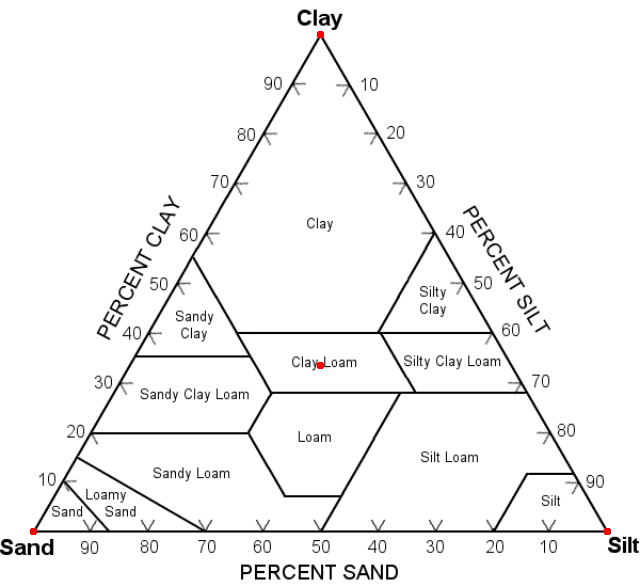

In [0]:
from ipywidgets import FloatText, Dropdown, RadioButtons, Button, Text
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output
import ipywidgets as widgets
from io import BytesIO
import requests
import os

"""
To add a new chart, add a record to the "charts" list below in the following form:

("NAME OF CHART", "URL TO IMAGE", (X,Y,"TOP LABEL"), (X,Y,"LEFT LABEL"), (X,Y,"RIGHT LABEL")),

X and Y are the coordinates of the relevant point in the image. This can be found 
using any photo editing software, including Microsoft Paint.

It is important that the points are listed in the order of top, left, right.
"""

charts = [("Blank", "https://www.kindpng.com/picc/m/443-4433696_ternary-plot-2-blank-ternary-diagram-hd-png.png", (428,62,"Top"), (64,691,"Left"), (793,691,"Right")),
          ("Soil", "https://www.thoughtco.com/thmb/hBJsCHJvPcTfLT0fg6bOWUeaTIU=/640x587/filters:fill(auto,1)/Sand-silt-clayclassificationdiagram-5a26c2b0ec2f6400371974db.png", (320,34,"Clay"), (33,531,"Sand"), (607,531,"Silt")),
          ("Igneous Rock", "https://www.thoughtco.com/thmb/gTdgM5httOEk3n6X1yzf-5KISQ8=/600x565/filters:no_upscale():max_bytes(150000):strip_icc()/600QAPplutonic-56a367bb5f9b58b7d0d1c834.jpg", (300,27,"Q"), (30,494,"A"), (570,494,"P")),
          
          ]


def plot_point(A, B, C, color, which, image):
  # To avoid dividing by zero.
  if A == 0 and B == 0 and C == 0:
    A = 1
    B = 1
    C = 1

  # Get the locations of the top, left, and right points in the image.
  top = (charts[which][2][0],charts[which][2][1])
  left = (charts[which][3][0],charts[which][3][1])
  right = (charts[which][4][0],charts[which][4][1])

  # Scale the values in proportion to sum to 1.0 if they don't already.
  G = (B + C + A) / 1.0
  B = B * G
  C = C * G
  A = A * G

  # Calculate x, y for the values with points A,B,C located at (0.5,1),(0,0),(1,0)
  x = (2.0 * C + A) / (A + B + C) / 2.0
  y = A / (A + B + C)

  # Scale x and y to proper dimensions for the chart, flipping the y axis, and
  # offsetting the points so that they line up with the image.
  x = (x * (right[0] - left[0])) + left[0]
  y = (-y * (left[1] - top[1])) + left[1]

  # Draw the dot on the image.
  r = 3
  leftUpPoint = (x-r, y-r)
  rightDownPoint = (x+r, y+r)
  twoPointList = [leftUpPoint, rightDownPoint]
  draw = ImageDraw.Draw(image)
  draw.ellipse(twoPointList, fill = color, outline =color)

  # Draw the label on the image.
  fnt = ImageFont.truetype("NotoMono-Regular.ttf", 20)    
  draw.text((x, y), text_label.value, fill=color, font=fnt)

  return


def update_labels(*args):
  # A utility function that updates the titles of the A, B, and C text fields
  # when a chart is selected.
  a_widget.description = charts[which_plot.value][2][2]
  b_widget.description = charts[which_plot.value][3][2]
  c_widget.description = charts[which_plot.value][4][2]


def button_pressed(_):
  # We will need to write to these variables that were defined in the main part of the script.
  global current_image
  global current_url

  # Get image for chart if we don't have it already
  if current_url != charts[which_plot.value][1]:
    response = requests.get(charts[which_plot.value][1])
    current_image = Image.open(BytesIO(response.content))
    current_image = current_image.convert("RGB")
    current_image.thumbnail((1024,1024), Image.ANTIALIAS)
    current_url = charts[which_plot.value][1]

  # Put the dot on the image  
  plot_point(a_widget.value, b_widget.value, c_widget.value, color_value.value, which_plot.value, current_image)

  # Clear all output and rebuild it with new image.
  clear_output()
  display(ui)
  display(current_image)

  # Reset A, B, C, and Label values
  a_widget.value = 0.0
  b_widget.value = 0.0
  c_widget.value = 0.0
  text_label.value = ""


# Get font for labels if we don't have it already.
if not os.path.exists("NotoMono-Regular.ttf"):
  !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoMono-hinted.zip"
  !unzip "NotoMono-hinted.zip"

# Variables to store image and remember what URL it came from.
current_image = None
current_url = None

# Defining the various user interface elements.
which_plot = RadioButtons(description="Plots", options=[(i[0], j) for j, i in enumerate(charts)])
a_widget = FloatText(description=charts[which_plot.value][2][2],max=1.0, min=0.0, step=0.001)
b_widget = FloatText(description=charts[which_plot.value][3][2],max=1.0, min=0.0, step=0.001)
c_widget = FloatText(description=charts[which_plot.value][4][2],max=1.0, min=0.0, step=0.001)
text_label = Text(description="Label")
color_value = Dropdown(description="Color", options=["Red", "Blue", "Green", "Orange", "Purple", "Brown", "Pink", "Gray", "Black", "White"])
save_button = Button(description='Add point')
ui = widgets.HBox([a_widget, b_widget, c_widget, color_value, text_label, save_button])

# Makes it so that when which_plot changes value, it calls update_labels to change the labels for the A, B, and C fields.
which_plot.observe(update_labels, 'value')

# Makes it so that clicking the "Add Point" button calls the button_pressed function.
save_button.on_click(button_pressed)

# Clear any output from downloading font, and display user interface elements
clear_output()
display(which_plot)
display(ui)

